<a href="https://colab.research.google.com/github/GeraldineQuispeT/Data_Discovery/blob/main/Outlier_and_Anomaly_Detection_tarea_GERALDINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://posgrado.utec.edu.pe/sites/default/files/2023-08/Testimonial-home-2.jpg" alt="HTML5 Icon" width="900" height="250" >

#**Laboratorio: Detección de Outliers en Datos de Taxis de NYC**

---

##**Objetivo general**

Aplicar técnicas de detección de outliers sobre datos reales de viajes en taxi en la ciudad de Nueva York, analizando su fundamento teórico, forma de implementación y capacidad para identificar observaciones atípicas en un entorno multivariado.

## **1. Introducción**

Los valores atípicos (**outliers**) son observaciones que se alejan significativamente del patrón general de los datos. Su detección es crucial en tareas de análisis exploratorio, limpieza, modelado y monitoreo.

Este laboratorio aborda técnicas univariadas y multivariadas para detectar outliers, usando datos simulados basados en el NYC Taxi Dataset.

Se aplicarán cinco métodos:


- Z-score

- IQR (boxplot)

- DBSCAN

- LOF (Local Outlier Factor)

- Isolation Forest

### **Descargar Data**

Este conjunto de datos contiene información detallada sobre millones de viajes en taxi realizados en la ciudad de Nueva York durante el año 2018.

Es un dataset clásico para análisis de movilidad, detección de anomalías, pricing dinámico y aprendizaje automático.

Cada fila representa un viaje individual y las columnas incluyen:

  > **pickup_datetime y dropoff_datetime**: fechas y horas de inicio y fin del viaje.
  >
  > **trip_distance**: distancia total recorrida (en millas).
  >
  > **fare_amount**: monto base de la tarifa del viaje.
  >
  > **tip_amount**: monto de la propina.
  >
  > **payment_type**: tipo de pago (efectivo, tarjeta, etc.).
  >
  > **passenger_coun**: número de pasajeros.
  >
  > **pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude**: coordenadas geográficas del viaje.


**Fuente:** https://www.kaggle.com/datasets/neilclack/nyc-taxi-trip-data-google-public-data?select=original_cleaned_nyc_taxi_data_2018.csv

In [1]:
import pandas as pd

path = "original_cleaned_nyc_taxi_data_2018.csv"

df = pd.read_csv(path).sample(n=20_000, random_state=42)
df.head()


,Unnamed: 0,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
3889775,4144169,7.40,1,Y,2,28.0,0.5,0.5,0.00,0.0,...,29.30,48,82,2018,3,27,1,0,2876.0,35.16
6908713,7472631,9.00,1,N,1,27.5,0.5,0.5,5.75,0.0,...,34.55,261,202,2018,12,3,0,22,2433.0,47.47
4149018,4425107,7.80,1,N,1,23.5,0.5,0.5,3.72,0.0,...,28.52,186,116,2018,10,17,2,3,3469.0,31.60
6816202,7366751,11.78,1,N,1,33.0,0.5,0.5,6.86,0.0,...,41.16,138,64,2018,5,4,4,23,1549.0,30.35
6140876,6614733,8.43,1,N,1,24.5,0.0,0.5,2.00,0.0,...,27.30,13,263,2018,11,12,0,19,2702.0,27.95


In [2]:
df.shape

(20000, 21)

## **2. Z-score**

### **2.1 Fundamento teórico**


El Z-score indica cuántas desviaciones estándar se encuentra un valor con respecto a la media.

Se define como:


<img src="https://almablog-media.s3.ap-south-1.amazonaws.com/image015_fd507da112.jpg" alt="HTML5 Icon" width="400" height="200" >

Se considera outlier todo valor con ∣𝑍𝑖∣>3, bajo el supuesto de normalidad.

## **2.2 Implementación**

In [3]:
from scipy.stats import zscore

variables = ['fare_amount', 'trip_distance']
for var in variables:
    df[f"{var}_z"] = zscore(df[var])
    df[f"{var}_outlier_z"] = df[f"{var}_z"].abs() > 3


##**3. IQR (Boxplot)**

### **3.1 Fundamento teórico**

El rango intercuartílico (IQR) se define como:

IQR=Q3−Q1

Donde:

> 𝑄1: percentil 25
>
> 𝑄3: percentil 75






<img src="https://www.simplypsychology.org/wp-content/uploads/boxplot-1.jpg" alt="HTML5 Icon" width="500" height="200" >

Se considera outlier todo valor fuera de:

(Q1−1.5⋅IQR, Q3+1.5⋅IQR)

### **3.2 Implementación**

In [4]:
def detect_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)

df['iqr_outlier_fare'] = detect_iqr_outliers(df['fare_amount'])


## **4. DBSCAN**

### **4.1 Fundamento teórico**

**DBSCAN** detecta agrupamientos por densidad. Un punto se considera outlier si tiene menos de min_samples vecinos dentro de un radio eps.




<img src="https://mineracaodedados.wordpress.com/wp-content/uploads/2018/02/dbscan.png" alt="HTML5 Icon" width="500" height="300" >



### **4.2 Implementación**

In [5]:
# Reducimos el tamaño con muestreo aleatorio reproducible
df_sample = df[['trip_distance', 'fare_amount', 'trip_duration']].dropna()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

X_scaled = StandardScaler().fit_transform(df_sample)

dbscan = DBSCAN(eps=1.2, min_samples=10)
df['dbscan_label'] = dbscan.fit_predict(X_scaled)
df['dbscan_outlier'] = df['dbscan_label'] == -1


## **5. LOF (Local Outlier Factor)**

### **5.1 Fundamento teórico**

LOF compara la densidad local de un punto con la de sus vecinos. Si un punto tiene baja densidad relativa, se considera un outlier.




<img src="https://qu4nt.github.io/sklearn-doc-es/_images/sphx_glr_plot_lof_novelty_detection_001.png" alt="HTML5 Icon" width="450" height="300" >

### **5.2 Implementación**

In [6]:
df_sample = df[['trip_distance', 'fare_amount', 'trip_duration']].dropna()

from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(df_sample)

In [7]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof = lof.fit(X_scaled)

df['lof_score'] = lof.fit_predict(X_scaled)
df['lof_outlier'] = df['lof_score'] == -1

## **6. Isolation Forest**

### **6.1 Fundamento teórico**

Isolation Forest aísla puntos de forma aleatoria. Los outliers, al estar más aislados, requieren menos divisiones. Eso se traduce en una menor profundidad media del árbol.



<img src="https://media.licdn.com/dms/image/v2/D4D08AQEiI2518F5qhg/croft-frontend-shrinkToFit1024/croft-frontend-shrinkToFit1024/0/1700684114746?e=2147483647&v=beta&t=w-7UygZ_NYGxA30dvc6GbDc5OSQgq1ASAdSukZ8ENFY" alt="HTML5 Icon" width="500" height="280" >

### **6.2 Implementación**

In [8]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['if_outlier'] = iso.fit_predict(X_scaled) == -1


## **7. Análisis Visual y Cuantitativo**

### **7.1 Boxplots para Z-score e IQR**

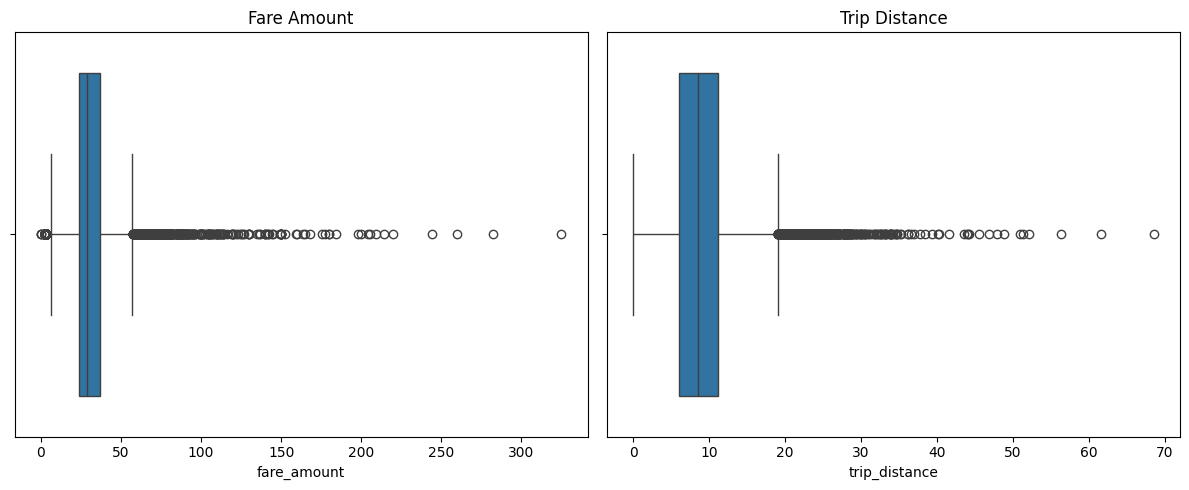

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df, x="fare_amount", ax=axes[0])
axes[0].set_title("Fare Amount")
sns.boxplot(data=df, x="trip_distance", ax=axes[1])
axes[1].set_title("Trip Distance")
plt.tight_layout()
plt.show()


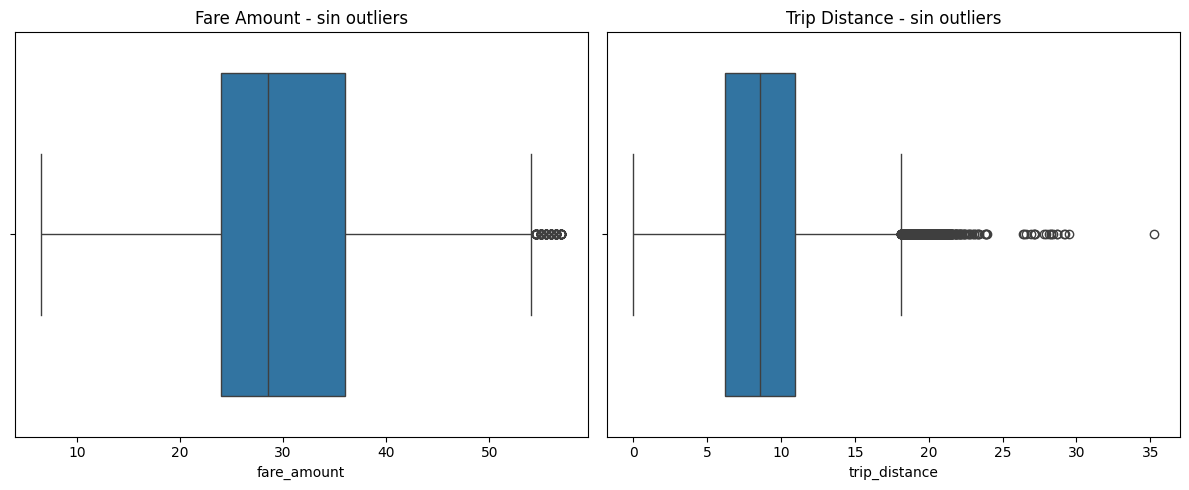

In [10]:
# Excluir outliers
df_no_outliers = df[~df['iqr_outlier_fare']]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df_no_outliers, x="fare_amount", ax=axes[0])
axes[0].set_title("Fare Amount - sin outliers")

sns.boxplot(data=df_no_outliers, x="trip_distance", ax=axes[1])
axes[1].set_title("Trip Distance - sin outliers")

plt.tight_layout()
plt.show()


### **7.2 Conteo de outliers por técnica**

In [11]:
print("Z-score Fare:", df["fare_amount_outlier_z"].sum())
print("Z-score Distance:", df["trip_distance_outlier_z"].sum())
print("IQR Fare:", df["iqr_outlier_fare"].sum())
print("DBSCAN:", df["dbscan_outlier"].sum())
print("LOF:", df["lof_outlier"].sum())
print("Isolation Forest:", df["if_outlier"].sum())

Z-score Fare: 223
Z-score Distance: 191
IQR Fare: 1552
DBSCAN: 48
LOF: 200
Isolation Forest: 200


## **8. Visualización de técnicas multivariadas**


### **8.1 DBSCAN**


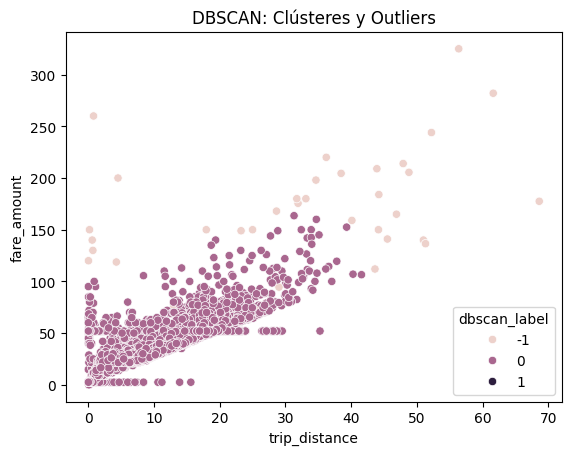

In [12]:
sns.scatterplot(data=df, x="trip_distance", y="fare_amount", hue=df["dbscan_label"])
plt.title("DBSCAN: Clústeres y Outliers")
plt.show()


### **8.2 LOF**

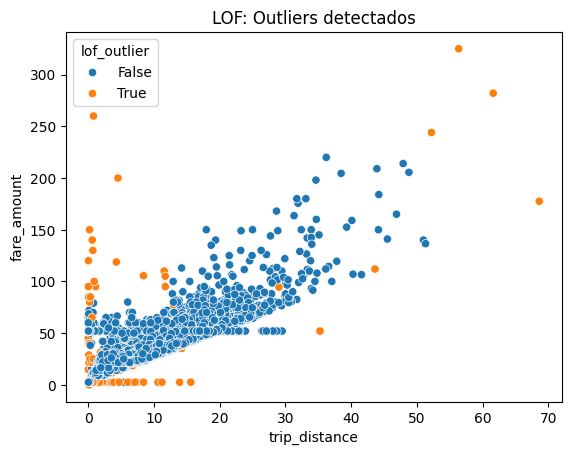

In [13]:
sns.scatterplot(data=df, x="trip_distance", y="fare_amount", hue=df["lof_outlier"])
plt.title("LOF: Outliers detectados")
plt.show()


### **8.3 Isolation Forest**

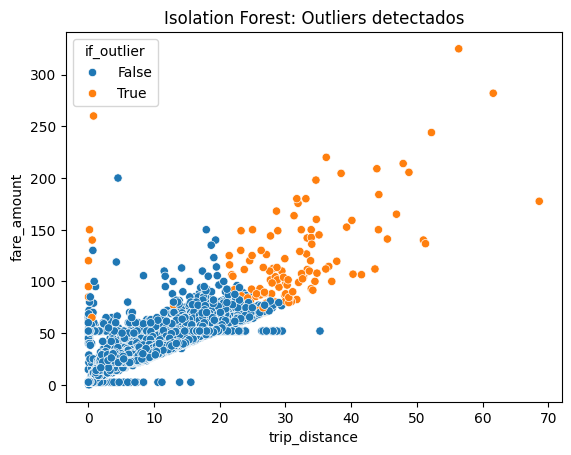

In [14]:
sns.scatterplot(data=df, x="trip_distance", y="fare_amount", hue=df["if_outlier"])
plt.title("Isolation Forest: Outliers detectados")
plt.show()


## **9. Comparación y análisis cruzado**

### **9.1 Conteo general**

In [15]:
outlier_cols = ['fare_amount_outlier_z', 'iqr_outlier_fare', 'dbscan_outlier', 'lof_outlier', 'if_outlier']
df[outlier_cols].sum()


,0
fare_amount_outlier_z,223
iqr_outlier_fare,1552
dbscan_outlier,48
lof_outlier,200
if_outlier,200


### **9.2 Coincidencias entre métodos**

In [16]:
df["lof_if"] = df["lof_outlier"] & df["if_outlier"]
df["z_iqr"] = df["fare_amount_outlier_z"] & df["iqr_outlier_fare"]

print("LOF & IF:", df["lof_if"].sum())
print("Z-score & IQR:", df["z_iqr"].sum())


LOF & IF: 26
Z-score & IQR: 223


### **9.3 Outliers detectados por múltiples métodos**

In [17]:
df["outlier_count"] = df[outlier_cols].sum(axis=1)
outliers_multi = df[df["outlier_count"] >= 3]
print("Outliers detectados por 3+ técnicas:", len(outliers_multi))


Outliers detectados por 3+ técnicas: 140


In [18]:
outliers_multi.head()

,Unnamed: 0,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,trip_distance_outlier_z,iqr_outlier_fare,dbscan_label,dbscan_outlier,lof_score,lof_outlier,if_outlier,lof_if,z_iqr,outlier_count
7794365,8499359,28.10,4,N,1,112.5,1.0,0.5,22.85,0.00,...,True,True,0,False,1,False,True,False,True,3
1474721,1541476,45.50,3,N,1,141.0,0.0,0.0,20.00,18.26,...,True,True,-1,True,1,False,True,False,True,4
1521463,1590363,24.70,3,N,1,86.0,0.0,0.0,21.00,18.70,...,True,True,0,False,1,False,True,False,True,3
7098413,7690874,43.61,1,N,1,112.0,0.5,0.5,34.22,57.80,...,True,True,-1,True,-1,True,True,True,True,5
196654,202650,1.11,5,N,1,95.0,0.0,0.0,10.00,0.00,...,False,True,0,False,-1,True,False,False,True,3


## **10. Conclusión**

Las técnicas univariadas como Z-score e IQR son simples pero limitadas en escenarios multivariados o distribuciones sesgadas. En cambio, técnicas como DBSCAN, LOF e Isolation Forest permiten detectar patrones más complejos, aunque requieren más configuración y análisis visual.

La detección de outliers no debe usarse de forma ciega. Debe combinarse con conocimiento del dominio, validación visual, y análisis de impacto en modelos posteriores. Una observación extrema no siempre es un error: puede ser una oportunidad.

---

## **Trabajo**

**Visualización comparativa de técnicas univariadas:**

Programa una función que grafique lado a lado los boxplots de fare_amount con y sin outliers (según IQR). ¿Cómo cambia la forma de la distribución al remover los outliers? ¿Cuántos valores fueron eliminados?

**Exploración de inconsistencias multivariadas:**

Escribe código para detectar viajes en los que la duración sea muy corta pero la tarifa total muy alta. Usa reglas lógicas personalizadas o una técnica no supervisada como Isolation Forest. ¿Cuántos casos detectas? ¿Qué podría explicarlos?

**Matriz de coincidencias entre técnicas de outliers:**

Crea una matriz de correlación binaria entre los métodos Z-score, IQR, DBSCAN, LOF e Isolation Forest (por columnas booleanas de outliers). ¿Qué técnicas coinciden más? Visualízalo con un heatmap.

**Función generalizada para aplicar DBSCAN:**

Implementa una función parametrizable aplicar_dbscan(df, variables, eps, min_samples) que permita probar distintas configuraciones de eps y min_samples sobre subconjuntos de variables. Evalúa cómo cambia la cantidad de outliers detectados.

**Perfil detallado de un outlier extremo:**

Elige una observación detectada como outlier por al menos 3 técnicas. Programa una función que grafique su posición relativa en cada una de las variables analizadas (fare_amount, trip_distance, tip_amount, etc.) comparada con el resto de los datos.

---

# Gracias por completar este laboratorio!

---


## Visualización comparativa de técnicas univariadas



Cantidad de outliers por tecnica IQR eliminados de 'fare_amount': 1552


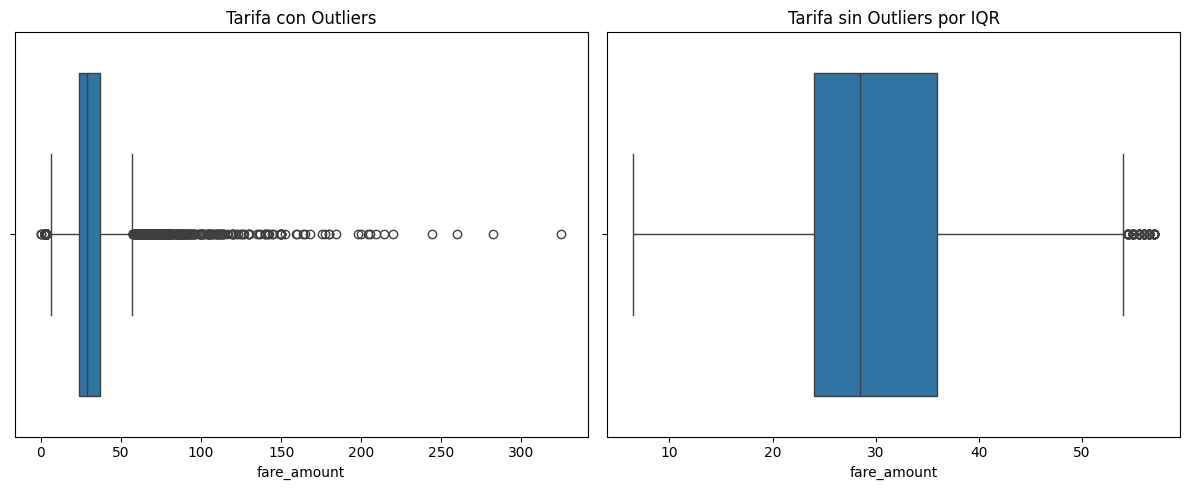

In [19]:
def plot_iqr_outlier_impact(df):
    original_rows = len(df)
    df_no_outliers_iqr = df[~df['iqr_outlier_fare']]
    filtered_rows = len(df_no_outliers_iqr)
    removed_outliers = original_rows - filtered_rows

    print(f"Cantidad de outliers por tecnica IQR eliminados de 'fare_amount': {removed_outliers}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.boxplot(data=df, x="fare_amount", ax=axes[0])
    axes[0].set_title("Tarifa con Outliers")

    sns.boxplot(data=df_no_outliers_iqr, x="fare_amount", ax=axes[1])
    axes[1].set_title("Tarifa sin Outliers por IQR")

    plt.tight_layout()
    plt.show()

plot_iqr_outlier_impact(df)

Conclusion: Se eliminaron 1552 valores outliers de IQR de la columna fare_amount, alterando significativamente su distribución, como se muestra en los boxplots comparativos luego de la eliminacion de outliers.

## Exploración de inconsistencias multivariadas


In [ ]:
short_duration_threshold = 300  # sen egundos
high_fare_threshold = 50  # en dólares

inconsistent_trips_mask = (df['trip_duration'] < short_duration_threshold) & (df['fare_amount'] > high_fare_threshold)
inconsistent_trips = df[inconsistent_trips_mask]

num_inconsistent_trips = len(inconsistent_trips)

print(f"Cantidad de viajes inconsistentes (por corta duración, por alta tarifa) usando el criterio previo: {num_inconsistent_trips}")

if_outliers = df[df['if_outlier']]

inconsistent_if_outliers_mask = (if_outliers['trip_duration'] < short_duration_threshold) & (if_outliers['fare_amount'] > high_fare_threshold)
inconsistent_if_outliers = if_outliers[inconsistent_if_outliers_mask]
num_inconsistent_if_outliers = len(inconsistent_if_outliers)

print(f"Cantidad de outliers de Isolation Forest que también son inconsistentes (por corta duración, por alta tarifa): {num_inconsistent_if_outliers}")


Cantidad de viajes inconsistentes (por corta duración, por alta tarifa) usando el criterio previo: 49
Cantidad de outliers de Isolation Forest que también son inconsistentes (por corta duración, por alta tarifa): 10


Conclusion: Se identificaron 49 viajes como inconsistentes utilizando una regla personalizada (duración < 300s, tarifa > \$50). Entre los outliers de Isolation Forest (considerando distancia, duración y tarifa), 10 datos también se ajustaban a este patrón de corta duración y alta tarifa. Es probable que al registrar la duración del viaje o el monto de la tarifa se haya cometido errores.Es probable que los viajes se haya tenido gastos altos por peajes o recargos por distancias cortas. Es probable que haya tarifas fijas en algunas zonas o servicios que no siguen estrictamente cálculos de distancia/duración. Asimismo viajes muy cortos podrian dar una tarifa mínima.

## Matriz de coincidencias entre técnicas de outliers




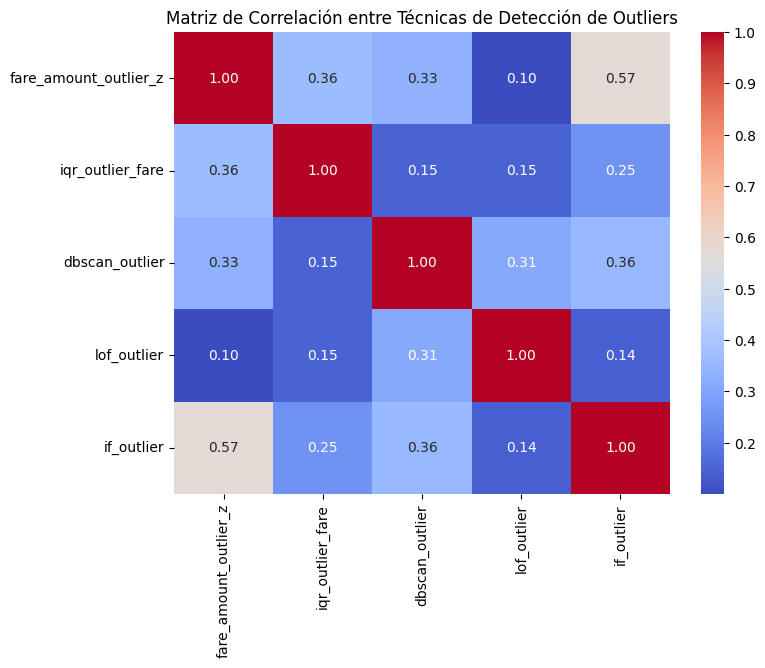

In [ ]:
outlier_cols = ['fare_amount_outlier_z', 'iqr_outlier_fare', 'dbscan_outlier', 'lof_outlier', 'if_outlier']
correlation_matrix = df[outlier_cols].corr()

plt.figure(figsize=(8, 6))
# Visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación entre Técnicas de Detección de Outliers")
plt.show()

Conclusiones: En el mapa de calor de la matriz de correlación se observa que diferentes técnicas de detección de outliers identifican conjuntos distintos de valores atípicos.

## Función generalizada para aplicar dbscan


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

def aplicar_dbscan(df, variables, eps, min_samples):

    df_subset = df[variables].dropna()

    if df_subset.empty:
        print(f"Advertencia: No hay puntos de datos disponibles después de eliminar NaNs para las variables: {variables}")
        return 0

    X_scaled = StandardScaler().fit_transform(df_subset)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_scaled)

    num_outliers = sum(dbscan_labels == -1)
    return num_outliers

variables_set1 = ['trip_distance', 'fare_amount']
variables_set2 = ['trip_distance', 'fare_amount', 'trip_duration']

print("Probando DBSCAN con diferentes parámetros:")
print(f"Variables: {variables_set1}, eps=0.5, min_samples=5: {aplicar_dbscan(df, variables_set1, eps=0.5, min_samples=5)} outliers")
print(f"Variables: {variables_set1}, eps=1.0, min_samples=10: {aplicar_dbscan(df, variables_set1, eps=1.0, min_samples=10)} outliers")
print(f"Variables: {variables_set2}, eps=0.8, min_samples=8: {aplicar_dbscan(df, variables_set2, eps=0.8, min_samples=8)} outliers")
print(f"Variables: {variables_set2}, eps=1.2, min_samples=10: {aplicar_dbscan(df, variables_set2, eps=1.2, min_samples=10)} outliers")

Probando DBSCAN con diferentes parámetros:
Variables: ['trip_distance', 'fare_amount'], eps=0.5, min_samples=5: 84 outliers
Variables: ['trip_distance', 'fare_amount'], eps=1.0, min_samples=10: 58 outliers
Variables: ['trip_distance', 'fare_amount', 'trip_duration'], eps=0.8, min_samples=8: 91 outliers
Variables: ['trip_distance', 'fare_amount', 'trip_duration'], eps=1.2, min_samples=10: 62 outliers


Conclusion: El número de outliers detectados por DBSCAN es altamente sensible a los parámetros eps y min_samples elegidos, así como a las variables de entrada (trip_distance, fare_amount, trip_duration), con recuentos que varían según la configuración.

## Perfil detallado de un outlier extremo


Outlier Seleccionado:


,75423
Unnamed: 0,77031
trip_distance,0.3
rate_code,1
store_and_fwd_flag,N
payment_type,1
fare_amount,3.0
extra,0.0
mta_tax,0.5
tip_amount,0.57
tolls_amount,0.0


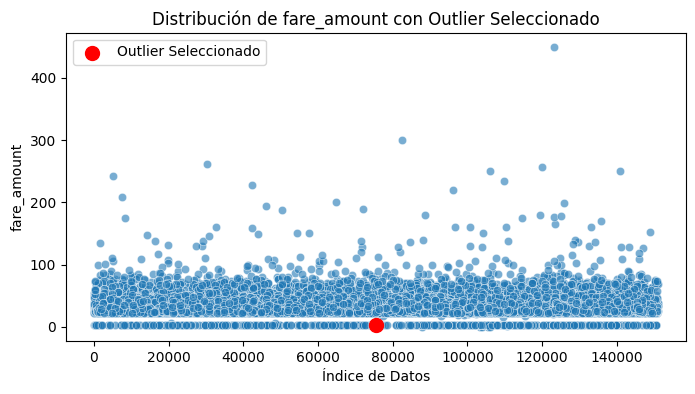

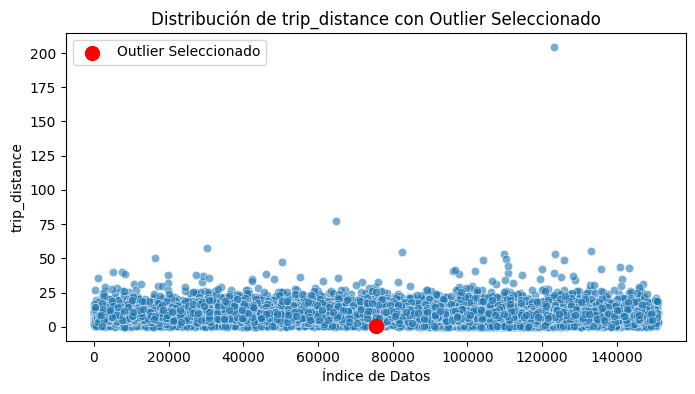

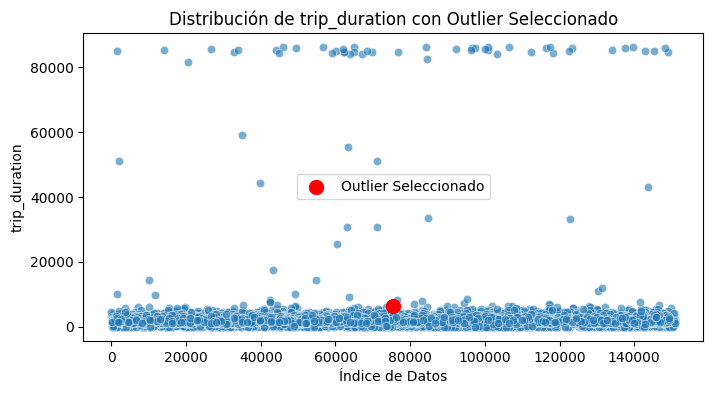

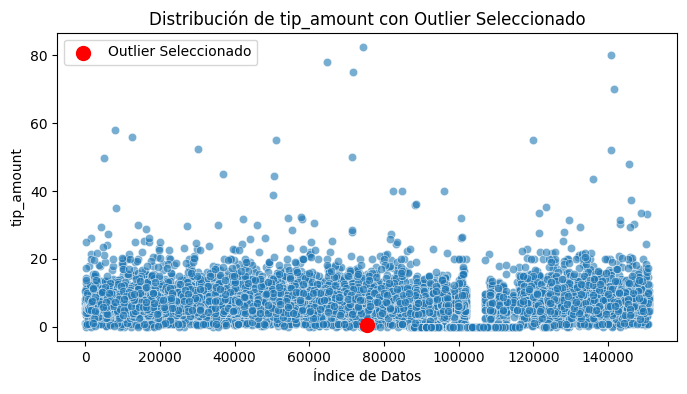

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if not outliers_multi.empty:
    outlier_example = outliers_multi.iloc[0]
    print("Outlier Seleccionado:")
    display(outlier_example)

    features_to_plot = ['fare_amount', 'trip_distance', 'trip_duration', 'tip_amount']

    outlier_data_for_plotting = outlier_example[features_to_plot].dropna()
    features_to_plot_clean = outlier_data_for_plotting.index.tolist()

    for feature in features_to_plot_clean:
        plt.figure(figsize=(8, 4))
        sns.scatterplot(data=df, x=df.index, y=feature, alpha=0.6)
        plt.scatter(outlier_example.name, outlier_example[feature], color='red', s=100, label='Outlier Seleccionado', zorder=5)
        plt.title(f'Distribución de {feature} con Outlier Seleccionado')
        plt.xlabel('Índice de Datos')
        plt.ylabel(feature)
        plt.legend()
        plt.show()
else:
    print("No se detectaron outliers por múltiples técnicas.")

Conclusiones: Un outlier específico (índice 75423) detectado por al menos cuatro métodos exhibió un fare_amount, tip_amount y total_amount excepcionalmente altos a pesar de tener una trip_duration moderada y una trip_distance relativamente corta.